In [26]:
# PCA Analysis: Hidden State Structure Across Layers

import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from utils.grid_utils import *
from utils.model_utils import *

MODEL_PATH = "/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/fv1_model_chunked/scheckpoint-73000"
model, tokenizer = load_model_and_tokenizer(MODEL_PATH)

def run_pca_analysis(model, tokenizer, layer_idx, grid_size=3, num_prompts=500, walk_length=120):
    """Run PCA analysis on hidden states for a specific layer."""
    print(f"Running PCA analysis for Layer {layer_idx}...")
    
    all_points = []
    num_nodes = grid_size * grid_size
    
    for _ in tqdm(range(num_prompts), desc=f"Layer {layer_idx}"):
        # Generate new grid with random names for each prompt
        current_nodes = generate_random_names(num_nodes)
        
        G = get_grid_graph(current_nodes, size=grid_size)
        grid_nodes = list(G.nodes())  # returns nodes in grid order
        current_pos_map = {}
        
        # Map each node to its actual position in the grid
        for i, node in enumerate(grid_nodes):
            r = i // grid_size
            c = i % grid_size
            current_pos_map[node] = (r, c)
        
        # Generate walk
        start_node = random.choice(current_nodes)
        walk = generate_random_walk(G, start_node, walk_length)
        prompt = walk_to_string(walk, G)
        
        # Get hidden states
        tokens = tokenizer(prompt, return_tensors="pt").to(DEVICE)
        hidden_states = get_hidden_states(model, tokens, layer_idx)
        
        # Extract node embeddings
        for node in current_nodes:
            # Find all occurrences of this node in the prompt
            node_positions = []
            token_strings = tokenizer.convert_ids_to_tokens(tokens['input_ids'][0])
            
            for i, token_str in enumerate(token_strings):
                if node in token_str:
                    node_positions.append(i)
            
            if node_positions:
                # Average embeddings across all occurrences
                node_vectors = hidden_states[0, node_positions, :].cpu().numpy()
                avg_vector = np.mean(node_vectors, axis=0)
                all_points.append({
                    "vector": avg_vector,
                    "coordinate": current_pos_map[node]
                })
    
    print(f"Collected {len(all_points)} node vectors")
    return all_points

def plot_coordinate_colored_pca(points, layer_idx, grid_size=3):
    """Plot PCA colored by grid coordinates (exactly like your original code)."""
    if not points:
        print("No points to plot")
        return
    
    # Prepare data
    X = np.array([p["vector"] for p in points])
    coords = [p["coordinate"] for p in points]
    
    # Run PCA
    pca = PCA(n_components=2, random_state=42)
    X2 = pca.fit_transform(X)
    
    num_coords = grid_size * grid_size
    colors = sns.color_palette("husl", n_colors=num_coords)
    coord_to_color = {(r, c): colors[r * grid_size + c]
                      for r in range(grid_size) for c in range(grid_size)}
    
    # Plotting stuff
    fig, ax = plt.subplots(figsize=(7, 6))
    
    for r in range(grid_size):
        for c in range(grid_size):
            coord = (r, c)
            color = coord_to_color[coord]
            idxs = [i for i, cc in enumerate(coords) if cc == coord]
            if idxs:
                ax.scatter(X2[idxs, 0], X2[idxs, 1], color=color, s=40, alpha=1, label=f'({r},{c})')
    
    max_abs_x = np.max(np.abs(X2[:, 0])) * 1.1
    max_abs_y = np.max(np.abs(X2[:, 1])) * 1.1
    ax.set_xlim(-max_abs_x, max_abs_x)
    ax.set_ylim(-max_abs_y, max_abs_y)
    
    ax.set_xlabel("PC 1", fontsize=12)
    ax.set_ylabel("PC 2", fontsize=12)
    
    ax.legend(
        title="Coordinate (R,C)",
        loc="upper left",
        ncol=grid_size,
        fontsize=9,
        fancybox=True
    )
    
    ax.grid(True, linestyle="--", alpha=0.4)
    fig.tight_layout()
    plt.show()
    
    return pca, X2

import plotly.express as px
import pandas as pd

def plot_interactive_3d_pca(points, layer_idx, grid_size=4):
    """Plot interactive 3D PCA colored by grid coordinates using Plotly."""
    if not points:
        print("No points to plot")
        return
    
    X = np.array([p["vector"] for p in points])
    coords = [p["coordinate"] for p in points]
    
    pca = PCA(n_components=3, random_state=42)
    X3 = pca.fit_transform(X)
    
    df = pd.DataFrame(X3, columns=['PC1', 'PC2', 'PC3'])
    df['coordinate'] = [str(c) for c in coords]
    
    print("Generating interactive 3D scatter plot...")

    fig = px.scatter_3d(
        df,
        x='PC1',
        y='PC2',
        z='PC3',
        color='coordinate',
        title=f"Layer {layer_idx} Hidden States - 3D PCA by Grid Coordinates",
        labels={'PC1': 'PC 1', 'PC2': 'PC 2', 'PC3': 'PC 3'},
        color_discrete_sequence=px.colors.sequential.Plasma
    )

    fig.update_layout(
        margin=dict(l=0, r=0, b=0, t=40),
        legend_title_text='Coordinate (R,C)'
    )
    
    # Optional: save
    # output_filename = f"3d_pca_L{layer_idx}.html"
    # fig.write_html(output_filename)
    # print(f"Interactive plot saved to: {output_filename}")
    
    fig.show()
    
    return pca, X3

In [ ]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import random
from sklearn.decomposition import PCA
import plotly.express as px

from utils.grid_utils import *
from utils.model_utils import *


def collect_embeddings(model, tokenizer, num_prompts, layer_idx, grid_size, walk_length, 
                       analysis_target, aggregation_method):
    """
    Collects embeddings with a choice of aggregation method.
    """
    print(f"Collecting embeddings for '{analysis_target}' with aggregation: '{aggregation_method}'...")
    all_points = []
    num_nodes = grid_size * grid_size

    for _ in tqdm(range(num_prompts), desc=f"Processing prompts"):
        current_nodes = generate_random_names(num_nodes)
        G = get_grid_graph(current_nodes, size=grid_size)
        pos_map = {current_nodes[i]: (i // grid_size, i % grid_size) for i in range(num_nodes)}
        
        start_node = random.choice(current_nodes)
        walk = generate_random_walk(G, start_node, walk_length)
        prompt = walk_to_string(walk, G)
        
        hidden_states, offsets = get_hidden_states_with_offsets(model, tokenizer, prompt, layer_idx)
        
        if aggregation_method == 'average':
            temp_vectors = {}
            if analysis_target == 'nodes':
                for node in set(walk):
                    pos_list = substring_positions(prompt, node)
                    for span in pos_list:
                        vec = gather_embeddings_for_span(hidden_states, offsets, span)
                        if vec is not None: temp_vectors.setdefault(node, []).append(vec)
                for node, vecs in temp_vectors.items():
                    all_points.append({"vector": np.mean(np.array(vecs), axis=0), "coordinate": pos_map[node]})
            elif analysis_target == 'directions':
                for direction in ["NORTH", "SOUTH", "EAST", "WEST"]:
                    pos_list = substring_positions(prompt, direction)
                    for span in pos_list:
                        vec = gather_embeddings_for_span(hidden_states, offsets, span)
                        if vec is not None: temp_vectors.setdefault(direction, []).append(vec)
                for direction, vecs in temp_vectors.items():
                    all_points.append({"vector": np.mean(np.array(vecs), axis=0), "direction": direction})

        elif aggregation_method == 'all':
            if analysis_target == 'nodes':
                current_char_offset = 0
                for i, node in enumerate(walk):
                    span_start = prompt.find(node, current_char_offset)
                    if span_start == -1: continue
                    span = [span_start, span_start + len(node)]
                    vec = gather_embeddings_for_span(hidden_states, offsets, span)
                    if vec is not None:
                        all_points.append({"vector": vec, "coordinate": pos_map[node], "path_index": i})
                    current_char_offset = span[1]
            elif analysis_target == 'directions':
                parts = prompt.split()
                current_char_offset = 0
                for i in range(1, len(parts), 2):
                    direction = parts[i]; node_before = parts[i-1]
                    preceding_node_pos = prompt.find(node_before, current_char_offset)
                    if preceding_node_pos != -1:
                        span_start = preceding_node_pos + len(node_before) + 1
                        span = [span_start, span_start + len(direction)]
                        vec = gather_embeddings_for_span(hidden_states, offsets, span)
                        if vec is not None:
                            # --- THIS IS THE ONLY MODIFIED LINE ---
                            direction_index = (i - 1) // 2
                            all_points.append({"vector": vec, "direction": direction, "path_index": direction_index})
                        current_char_offset = span[1]
                        
    print(f"Collected {len(all_points)} data points.")
    return all_points


def plot_pca_2d(points, title, color_by, grid_size):
    if not points: print(f"No points to plot for '{title}'"); return
    X = np.array([p["vector"] for p in points]); labels = [p[color_by] for p in points]
    pca = PCA(n_components=2, random_state=42); X2 = pca.fit_transform(X)
    fig, ax = plt.subplots(figsize=(7, 6))
    if color_by == 'path_index':
        scatter = ax.scatter(X2[:, 0], X2[:, 1], c=labels, cmap='viridis', s=40, alpha=1.0)
        cbar = fig.colorbar(scatter, ax=ax); cbar.set_label("Path Index", fontsize=12)
    else:
        unique_labels = sorted(list(set(labels)), key=lambda x: str(x))
        if color_by == 'coordinate':
            cmap = plt.cm.get_cmap('plasma', len(unique_labels)); colors = [cmap(i) for i in range(len(unique_labels))]
            legend_title = "Coordinate (R,C)"
        else:
            colors = sns.color_palette("Set2", n_colors=len(unique_labels)); legend_title = "Direction"
        label_to_color = {label: colors[i] for i, label in enumerate(unique_labels)}
        for label in unique_labels:
            idxs = [i for i, l in enumerate(labels) if l == label]
            ax.scatter(X2[idxs, 0], X2[idxs, 1], color=label_to_color[label], label=str(label), s=40, alpha=1.0)
        ax.legend(title=legend_title, loc="upper left", ncol=grid_size if color_by == 'coordinate' else 2, fontsize=9, fancybox=True)
    max_abs_x = np.max(np.abs(X2[:, 0]))*1.1; max_abs_y = np.max(np.abs(X2[:, 1]))*1.1
    ax.set_xlim(-max_abs_x, max_abs_x); ax.set_ylim(-max_abs_y, max_abs_y)
    ax.set_xlabel("PC 1", fontsize=12); ax.set_ylabel("PC 2", fontsize=12)
    ax.set_title(title, fontsize=16); ax.grid(True, linestyle="--", alpha=0.4); fig.tight_layout(); plt.show()

def plot_pca_3d(points, title, color_by):
    if not points: print(f"No points to plot for '{title}'"); return
    print(f"Generating interactive 3D plot for: {title}")
    X = np.array([p["vector"] for p in points]); pca = PCA(n_components=3, random_state=42); X3 = pca.fit_transform(X)
    df = pd.DataFrame(X3, columns=['PC1', 'PC2', 'PC3'])
    df[color_by] = [str(p[color_by]) if isinstance(p[color_by], tuple) else p[color_by] for p in points]
    color_opts = {}
    if color_by == 'path_index':
        color_opts['color_continuous_scale'] = 'Viridis'; df[color_by] = pd.to_numeric(df[color_by])
    elif color_by == 'coordinate':
        color_opts['color_discrete_sequence'] = px.colors.sequential.Plasma
    elif color_by == 'direction':
        color_opts['color_discrete_sequence'] = px.colors.qualitative.Set2
    fig = px.scatter_3d(df, x='PC1', y='PC2', z='PC3', color=color_by, title=title, labels={'PC1': 'PC 1', 'PC2': 'PC 2', 'PC3': 'PC 3'}, **color_opts)
    fig.update_layout(margin=dict(l=0, r=0, b=0, t=40), legend_title_text=color_by.replace('_', ' ').title()); fig.show()


def run_analysis(model_path, layer_idx, num_prompts, grid_size, walk_length, 
                 analysis_target, color_by, aggregation_method):
    """Main analysis orchestrator with aggregation control."""
    if aggregation_method == 'average' and color_by == 'path_index':
        raise ValueError("Cannot color by 'path_index' when using 'average' aggregation.")

    valid_targets = {
        'coordinate': ['nodes'],
        'path_index': ['nodes', 'directions'], # Added directions
        'direction': ['directions']
    }
    if analysis_target not in valid_targets.get(color_by, []):
        raise ValueError(f"Cannot color by '{color_by}' for target '{analysis_target}'.")

    print("-" * 50)
    print(f"Starting RW Analysis:")
    print(f"  - Aggregation: {aggregation_method}")
    print(f"  - Target: {analysis_target}, Coloring by: {color_by}")
    print(f"  - Layer: {layer_idx}, Grid: {grid_size}x{grid_size}, Walk Length: {walk_length}")
    print("-" * 50)
    
    model, tokenizer = load_model_and_tokenizer(model_path)
    points = collect_embeddings(model, tokenizer, num_prompts, layer_idx, grid_size, 
                                walk_length, analysis_target, aggregation_method)
    
    if points:
        title_prefix = f"L{layer_idx}, {grid_size}x{grid_size} RW | Target: {analysis_target}"
        #plot_pca_2d(points, title=f"{title_prefix} (2D)", color_by=color_by, grid_size=grid_size)
        plot_pca_2d(points, title=f" Layer {layer_idx}", color_by=color_by, grid_size=grid_size)
        #plot_pca_3d(points, title=f"{title_prefix} (3D)", color_by=color_by)



--------------------------------------------------
Starting RW Analysis:
  - Aggregation: average
  - Target: nodes, Coloring by: coordinate
  - Layer: 7, Grid: 3x3, Walk Length: 50
--------------------------------------------------


Processing prompts:   0%|          | 0/500 [00:00<?, ?it/s]

Processing prompts: 100%|██████████| 500/500 [00:01<00:00, 259.82it/s]


Collected 4440 data points.


/tmp/ipykernel_211148/220588599.py:99: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



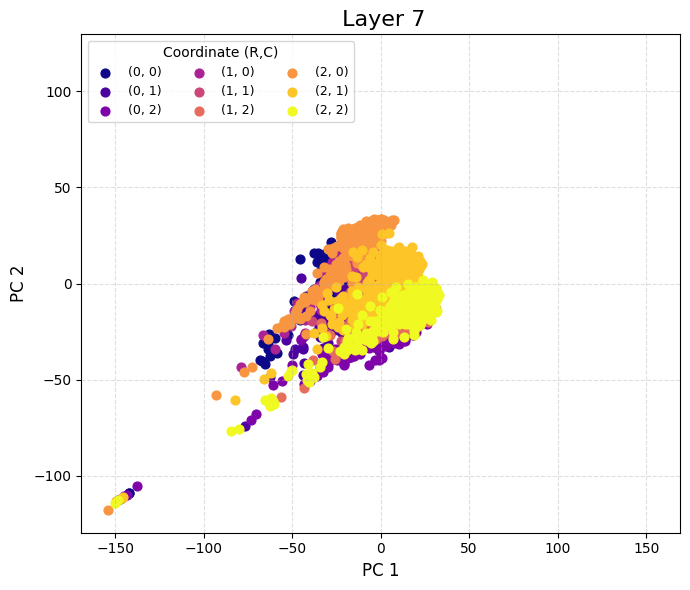

--------------------------------------------------
Starting RW Analysis:
  - Aggregation: average
  - Target: nodes, Coloring by: coordinate
  - Layer: 10, Grid: 3x3, Walk Length: 50
--------------------------------------------------


Processing prompts: 100%|██████████| 500/500 [00:01<00:00, 260.38it/s]
/tmp/ipykernel_211148/220588599.py:99: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



Collected 4406 data points.


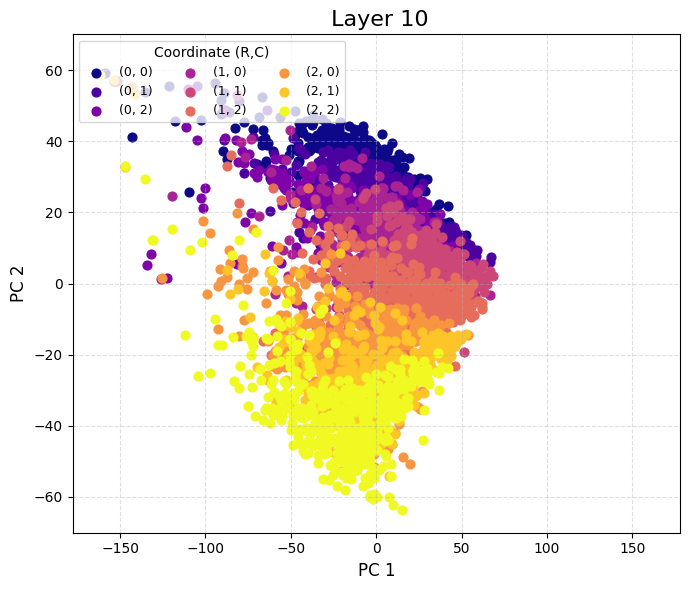

--------------------------------------------------
Starting RW Analysis:
  - Aggregation: average
  - Target: nodes, Coloring by: coordinate
  - Layer: 12, Grid: 3x3, Walk Length: 50
--------------------------------------------------


Processing prompts: 100%|██████████| 500/500 [00:01<00:00, 261.04it/s]
/tmp/ipykernel_211148/220588599.py:99: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



Collected 4418 data points.


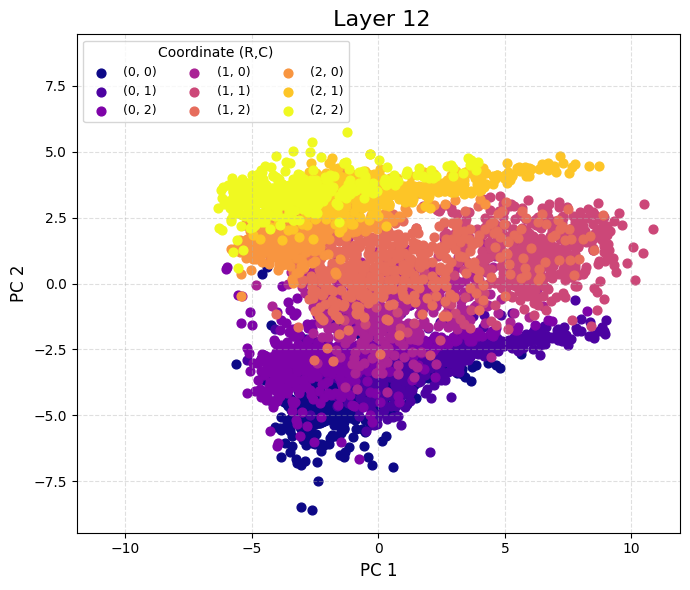

In [ ]:

MODEL_PATH = "/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/fv1_model_chunked/scheckpoint-73000" # <--- CHANGE THIS
LAYER_IDX = 12
NUM_PROMPTS = 500
GRID_SIZE = 3
WALK_LENGTH = 50


run_analysis(
    model_path=MODEL_PATH, layer_idx=7, num_prompts=NUM_PROMPTS, 
    grid_size=GRID_SIZE, walk_length=WALK_LENGTH,
    analysis_target='nodes',          # 'nodes' or 'directions'
    color_by='coordinate',             # 'coordinate', 'path_index'
    aggregation_method='average'       # 'average' or 'all'

)
run_analysis(
    model_path=MODEL_PATH, layer_idx=10, num_prompts=NUM_PROMPTS, 
    grid_size=GRID_SIZE, walk_length=WALK_LENGTH,
    analysis_target='nodes',          # 'nodes' or 'directions'
    color_by='coordinate',             # 'coordinate', 'path_index'
    aggregation_method='average'       # 'average' or 'all'

)
run_analysis(
    model_path=MODEL_PATH, layer_idx=12, num_prompts=NUM_PROMPTS, 
    grid_size=GRID_SIZE, walk_length=WALK_LENGTH,
    analysis_target='nodes',          # 'nodes' or 'directions'
    color_by='coordinate',             # 'coordinate', 'path_index'
    aggregation_method='average'       # 'average' or 'all'

)

In [ ]:
# WITH ARR DIRECTION
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import random
from sklearn.decomposition import PCA
import plotly.express as px


from utils.grid_utils import *
from utils.model_utils import *


def collect_embeddings(model, tokenizer, num_prompts, layer_idx, grid_size, walk_length, 
                       analysis_target, aggregation_method):
    """
    Collects embeddings with a choice of aggregation method.
    Now includes 'arrival_direction' for node analysis with 'all' aggregation.
    """
    print(f"Collecting embeddings for '{analysis_target}' with aggregation: '{aggregation_method}'...")
    all_points = []
    num_nodes = grid_size * grid_size

    for _ in tqdm(range(num_prompts), desc=f"Processing prompts"):
        current_nodes = generate_random_names(num_nodes)
        G = get_grid_graph(current_nodes, size=grid_size)
        pos_map = {current_nodes[i]: (i // grid_size, i % grid_size) for i in range(num_nodes)}
        
        start_node = random.choice(current_nodes)
        walk = generate_random_walk(G, start_node, walk_length)
        prompt = walk_to_string(walk, G)
        
        hidden_states, offsets = get_hidden_states_with_offsets(model, tokenizer, prompt, layer_idx)
        
        if aggregation_method == 'average':
            temp_vectors = {}
            if analysis_target == 'nodes':
                for node in set(walk):
                    pos_list = substring_positions(prompt, node)
                    for span in pos_list:
                        vec = gather_embeddings_for_span(hidden_states, offsets, span)
                        if vec is not None: temp_vectors.setdefault(node, []).append(vec)
                for node, vecs in temp_vectors.items():
                    all_points.append({"vector": np.mean(np.array(vecs), axis=0), "coordinate": pos_map[node]})
            elif analysis_target == 'directions':
                for direction in ["NORTH", "SOUTH", "EAST", "WEST"]:
                    pos_list = substring_positions(prompt, direction)
                    for span in pos_list:
                        vec = gather_embeddings_for_span(hidden_states, offsets, span)
                        if vec is not None: temp_vectors.setdefault(direction, []).append(vec)
                for direction, vecs in temp_vectors.items():
                    all_points.append({"vector": np.mean(np.array(vecs), axis=0), "direction": direction})

        elif aggregation_method == 'all':
            if analysis_target == 'nodes':
                path_directions = []
                for j in range(1, len(walk)):
                    prev_node, curr_node = walk[j-1], walk[j]
                    r1, c1 = pos_map[prev_node]
                    r2, c2 = pos_map[curr_node]
                    dr, dc = r2 - r1, c2 - c1
                    if (dr, dc) == (1, 0): path_directions.append('SOUTH')
                    elif (dr, dc) == (-1, 0): path_directions.append('NORTH')
                    elif (dr, dc) == (0, 1): path_directions.append('EAST')
                    elif (dr, dc) == (0, -1): path_directions.append('WEST')
                    else: path_directions.append('UNK')
                
                current_char_offset = 0
                for i, node in enumerate(walk):
                    span_start = prompt.find(node, current_char_offset)
                    if span_start == -1: continue
                    span = [span_start, span_start + len(node)]
                    vec = gather_embeddings_for_span(hidden_states, offsets, span)
                    if vec is not None:
                        point = {
                            "vector": vec, 
                            "coordinate": pos_map[node], 
                            "path_index": i,
                            "arrival_direction": 'Start' if i == 0 else path_directions[i - 1]
                        }
                        all_points.append(point)
                    current_char_offset = span[1]

            elif analysis_target == 'directions':
                parts = prompt.split()
                current_char_offset = 0
                for i in range(1, len(parts), 2):
                    direction = parts[i]; node_before = parts[i-1]
                    preceding_node_pos = prompt.find(node_before, current_char_offset)
                    if preceding_node_pos != -1:
                        span_start = preceding_node_pos + len(node_before) + 1
                        span = [span_start, span_start + len(direction)]
                        vec = gather_embeddings_for_span(hidden_states, offsets, span)
                        if vec is not None:
                            direction_index = (i - 1) // 2
                            all_points.append({"vector": vec, "direction": direction, "path_index": direction_index})
                        current_char_offset = span[1]
                        
    print(f"Collected {len(all_points)} data points.")
    return all_points


def plot_pca_2d(points, title, color_by, grid_size):
    if not points: print(f"No points to plot for '{title}'"); return
    X = np.array([p["vector"] for p in points]); labels = [p[color_by] for p in points]
    pca = PCA(n_components=2, random_state=42); X2 = pca.fit_transform(X)
    fig, ax = plt.subplots(figsize=(7, 6))
    if color_by == 'path_index':
        scatter = ax.scatter(X2[:, 0], X2[:, 1], c=labels, cmap='viridis', s=40, alpha=1.0)
        cbar = fig.colorbar(scatter, ax=ax); cbar.set_label("Path Index", fontsize=12)
    else:
        if color_by == 'arrival_direction':
            unique_labels = ['Start', 'NORTH', 'SOUTH', 'EAST', 'WEST']
            colors = ['black', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'] # Specific colors
            legend_title = "Arrival Direction"
        else:
            unique_labels = sorted(list(set(labels)), key=lambda x: str(x))
            if color_by == 'coordinate':
                cmap = plt.cm.get_cmap('plasma', len(unique_labels)); colors = [cmap(i) for i in range(len(unique_labels))]
                legend_title = "Coordinate (R,C)"
            else: # direction
                colors = sns.color_palette("Set2", n_colors=len(unique_labels)); legend_title = "Direction"

        label_to_color = {label: colors[i] for i, label in enumerate(unique_labels)}
        for label in unique_labels:
            if label not in labels: continue # Skip if a direction wasn't taken
            idxs = [i for i, l in enumerate(labels) if l == label]
            ax.scatter(X2[idxs, 0], X2[idxs, 1], color=label_to_color.get(label, 'grey'), label=str(label), s=40, alpha=1.0)
        ax.legend(title=legend_title, loc="upper left", ncol=grid_size if color_by == 'coordinate' else 2, fontsize=9, fancybox=True)
    max_abs_x = np.max(np.abs(X2[:, 0]))*1.1; max_abs_y = np.max(np.abs(X2[:, 1]))*1.1
    ax.set_xlim(-max_abs_x, max_abs_x); ax.set_ylim(-max_abs_y, max_abs_y)
    ax.set_xlabel("PC 1", fontsize=12); ax.set_ylabel("PC 2", fontsize=12)
    ax.set_title(title, fontsize=16); ax.grid(True, linestyle="--", alpha=0.4); fig.tight_layout(); plt.show()

def plot_pca_3d(points, title, color_by):
    if not points: print(f"No points to plot for '{title}'"); return
    print(f"Generating interactive 3D plot for: {title}")
    X = np.array([p["vector"] for p in points]); pca = PCA(n_components=3, random_state=42); X3 = pca.fit_transform(X)
    df = pd.DataFrame(X3, columns=['PC1', 'PC2', 'PC3'])
    df[color_by] = [str(p[color_by]) if isinstance(p[color_by], tuple) else p[color_by] for p in points]
    
    color_opts = {}
    if color_by == 'path_index':
        color_opts['color_continuous_scale'] = 'Viridis'; df[color_by] = pd.to_numeric(df[color_by])
    elif color_by == 'coordinate':
        color_opts['color_discrete_sequence'] = px.colors.sequential.Plasma
    elif color_by == 'direction':
        color_opts['color_discrete_sequence'] = px.colors.qualitative.Set2
    elif color_by == 'arrival_direction':
        color_opts['color_discrete_map'] = {
            'Start': 'black', 'NORTH': '#1f77b4', 'SOUTH': '#ff7f0e', 
            'EAST': '#2ca02c', 'WEST': '#d62728'
        }

    fig = px.scatter_3d(df, x='PC1', y='PC2', z='PC3', color=color_by, title=title, labels={'PC1': 'PC 1', 'PC2': 'PC 2', 'PC3': 'PC 3'}, **color_opts)
    fig.update_layout(margin=dict(l=0, r=0, b=0, t=40), legend_title_text=color_by.replace('_', ' ').title()); fig.show()


def run_analysis(model_path, layer_idx, num_prompts, grid_size, walk_length, 
                 analysis_target, color_by, aggregation_method):
    """Main analysis orchestrator with aggregation control."""
    if aggregation_method == 'average' and color_by in ['path_index', 'arrival_direction']:
        raise ValueError(f"Cannot color by '{color_by}' when using 'average' aggregation.")

    valid_targets = {
        'coordinate': ['nodes'],
        'path_index': ['nodes', 'directions'],
        'direction': ['directions'],
        'arrival_direction': ['nodes']
    }
    if analysis_target not in valid_targets.get(color_by, []):
        raise ValueError(f"Cannot color by '{color_by}' for target '{analysis_target}'.")

    print("-" * 50)
    print(f"Starting RW Analysis:")
    print(f"  - Aggregation: {aggregation_method}")
    print(f"  - Target: {analysis_target}, Coloring by: {color_by}")
    print(f"  - Layer: {layer_idx}, Grid: {grid_size}x{grid_size}, Walk Length: {walk_length}")
    print("-" * 50)
    

    points = collect_embeddings(model, tokenizer, num_prompts, layer_idx, grid_size, 
                                walk_length, analysis_target, aggregation_method)
    
    if points:
        title_prefix = f"L{layer_idx}, {grid_size}x{grid_size} RW | Target: {analysis_target}"
        plot_pca_2d(points, title=f" Layer {layer_idx}", color_by=color_by, grid_size=grid_size)
        plot_pca_3d(points, title=f"{title_prefix} (3D)", color_by=color_by, grid_size=grid_size)

In [30]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from sklearn.decomposition import PCA

def plot_interactive_pca(points, title_prefix, color_options, grid_size, save_path=None):
    if not points:
        print("No points to plot.")
        return

    print(f"Generating interactive PCA plot with color options: {color_options}")
    
    X = np.array([p["vector"] for p in points])
    pca = PCA(n_components=3, random_state=42)
    X3 = pca.fit_transform(X)
    
    df = pd.DataFrame(X3, columns=['PC1', 'PC2', 'PC3'])
    for option in color_options:
        df[option] = [str(p.get(option)) if isinstance(p.get(option), tuple) else p.get(option) for p in points]

    color_maps = {}
    for color_by in color_options:
        unique_vals_in_data = sorted(df[color_by].dropna().unique(), key=lambda x: int(x) if str(x).isdigit() else str(x))
        if color_by == 'arrival_direction':
            color_maps[color_by] = {'Start': 'black', 'NORTH': '#1f77b4', 'SOUTH': '#ff7f0e', 'EAST': '#2ca02c', 'WEST': '#d62728', 'UNK': 'grey'}
        elif color_by == 'coordinate':
            all_possible_coords = sorted([str((r, c)) for r in range(grid_size) for c in range(grid_size)])
            colors = px.colors.sample_colorscale("Plasma", len(all_possible_coords))
            color_maps[color_by] = {coord_str: color for coord_str, color in zip(all_possible_coords, colors)}
        elif color_by == 'path_index':
            df[color_by] = pd.to_numeric(df[color_by])
            numeric_indices = sorted(df[color_by].dropna().unique())
            colors = px.colors.sample_colorscale("Viridis", len(numeric_indices))
            color_maps[color_by] = {index: color for index, color in zip(numeric_indices, colors)}
        else:
            color_sequence = px.colors.qualitative.Set1
            color_maps[color_by] = {val: color_sequence[j % len(color_sequence)] for j, val in enumerate(unique_vals_in_data)}

    fig = go.Figure()
    trace_counts_per_option = {option: 0 for option in color_options}

    for i, color_by in enumerate(color_options):
        current_color_map = color_maps[color_by]
        unique_vals_in_data = sorted(df[color_by].dropna().unique(), key=lambda x: int(x) if str(x).isdigit() else str(x))

        for val in unique_vals_in_data:
            mask = (df[color_by] == val)
            hover_texts = []
            for idx in df[mask].index:
                hover_items = [f"<b>Point Index: {idx}</b>"]
                for opt in color_options:
                    hover_items.append(f"{opt.replace('_', ' ').title()}: {df.loc[idx, opt]}")
                hover_texts.append("<br>".join(hover_items))

            fig.add_trace(
                go.Scatter3d(
                    x=df.loc[mask, 'PC1'], y=df.loc[mask, 'PC2'], z=df.loc[mask, 'PC3'],
                    mode='markers',
                    marker=dict(size=5, color=current_color_map.get(val, 'grey')),
                    text=hover_texts,
                    hoverinfo='text',
                    name=str(val),
                    legendgroup=color_by,
                    visible=(i == 0)
                )
            )
        trace_counts_per_option[color_by] = len(unique_vals_in_data)

    buttons = []
    for i, color_by in enumerate(color_options):
        visibility = []
        for j, opt in enumerate(color_options):
            visibility.extend([i == j] * trace_counts_per_option[opt])
            
        buttons.append(
            dict(
                method='update',
                label=color_by.replace('_', ' ').title(),
                args=[{'visible': visibility},
                      {'legend.title.text': color_by.replace('_', ' ').title()}]
            )
        )

    fig.update_layout(
        title=title_prefix,
        updatemenus=[dict(active=0, buttons=buttons, direction="down", pad={"r": 10, "t": 10},
                          showactive=True, x=0.01, xanchor="left", y=0.99, yanchor="top")],
        scene=dict(xaxis_title='PC 1', yaxis_title='PC 2', zaxis_title='PC 3'),
        margin=dict(l=0, r=0, b=0, t=50),
        legend=dict(title=dict(text=color_options[0].replace('_', ' ').title()))
    )
    
    fig.show()
    
    if save_path:
        fig.write_html(save_path)
        print(f"Interactive plot saved to: {save_path}")

def run_analysis(model_path, layer_idx, num_prompts, grid_size, walk_length, 
                 analysis_target, aggregation_method):
    if aggregation_method == 'average':
        raise ValueError("This analysis pipeline is designed for 'all' aggregation to support rich, interactive plots.")

    print("-" * 50)
    print(f"Starting Interactive PCA Analysis:")
    print(f"  - Target: {analysis_target}, Aggregation: {aggregation_method}")
    print(f"  - Layer: {layer_idx}, Grid: {grid_size}x{grid_size}, Walk Length: {walk_length}")
    print("-" * 50)
    
    points = collect_embeddings(model, tokenizer, num_prompts, layer_idx, grid_size, 
                                walk_length, analysis_target, aggregation_method)
    
    if points:
        title_prefix = f"L{layer_idx}, {grid_size}x{grid_size} RW | Target: {analysis_target}"
        
        if analysis_target == 'nodes':
            color_opts = ['coordinate', 'path_index', 'arrival_direction']
        elif analysis_target == 'directions':
            color_opts = ['direction', 'path_index']
        else:
            color_opts = []

        plot_interactive_pca(
            points=points,
            title_prefix=title_prefix,
            color_options=color_opts,
            grid_size=grid_size,
            save_path=f"interactive_pca_L{layer_idx}_{analysis_target}.html"
        )

In [ ]:
# Run analysis coloring by arrival direction
run_analysis(
    model_path=MODEL_PATH,
    layer_idx=1,
    num_prompts=100,
    grid_size=3,
    walk_length=50,
    analysis_target='nodes',          # Must be 'nodes'
    aggregation_method='all'          # Must be 'all'
)

--------------------------------------------------
Starting Interactive PCA Analysis:
  - Target: nodes, Aggregation: all
  - Layer: 1, Grid: 3x3, Walk Length: 50
--------------------------------------------------


Processing prompts: 100%|██████████| 100/100 [00:00<00:00, 264.81it/s]


Collected 5000 data points.
Generating interactive PCA plot with color options: ['coordinate', 'path_index', 'arrival_direction']


Interactive plot saved to: interactive_pca_L1_nodes.html


In [ ]:
# Linear Probing Analysis

import os
import gc
import random
import numpy as np
import torch
from tqdm.auto import tqdm
from collections import defaultdict
from utils.grid_utils import *
from utils.model_utils import *

# Configuration
NUM_WALKS = 250
MAX_WALK_LENGTH = 120
MIN_WALK_LENGTH = 120
ACTIVATION_CACHE_PATH = 'activation_cache.pt'

class ActivationCache:
    def __init__(self, model):
        self.model = model
        self.hooks = []
        self.residual_cache = defaultdict(list)
        self.mlp_cache = defaultdict(list)

    def _get_residual_hook(self, layer_idx):
        def hook_fn(module, input, output):
            self.residual_cache[layer_idx].append(input[0].squeeze(0).detach().cpu())
        return hook_fn

    def _get_mlp_hook(self, layer_idx):
        def hook_fn(module, input, output):
            self.mlp_cache[layer_idx].append(output.squeeze(0).detach().cpu())
        return hook_fn

    def __enter__(self):
        for i, block in enumerate(self.model.transformer.h):
            self.hooks.append(block.register_forward_hook(self._get_residual_hook(i)))
            self.hooks.append(block.mlp.act.register_forward_hook(self._get_mlp_hook(i)))
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        for hook in self.hooks:
            hook.remove()

    def clear(self):
        self.residual_cache.clear()
        self.mlp_cache.clear()

def substring_positions(haystack, needle):
    """Find all occurrences of needle in haystack."""
    result = []
    start = 0
    while True:
        idx = haystack.find(needle, start)
        if idx == -1: break
        result.append((idx, idx + len(needle)))
        start = idx + 1
    return result

# Generate activation dataset
if os.path.exists(ACTIVATION_CACHE_PATH):
    os.remove(ACTIVATION_CACHE_PATH)

processed_data = []

with ActivationCache(model) as collector:
    pbar = tqdm(range(NUM_WALKS), desc="Generating walks")
    for _ in pbar:
        collector.clear()
        
        current_nodes = generate_random_names(16)
        G_walk = get_grid_graph(current_nodes, size=4)
        grid_nodes = list(G_walk.nodes()) # returns nodes in grid order
        node_to_coords_walk = {}
        
        # Map each node to its actual position in the grid
        for i, node in enumerate(grid_nodes):
            r = i // 4
            c = i % 4
            node_to_coords_walk[node] = (r, c)
        
        start_node = random.choice(list(G_walk.nodes()))
        length = random.randint(MIN_WALK_LENGTH, MAX_WALK_LENGTH)
        walk = generate_random_walk(G_walk, start_node, length)
        prompt = walk_to_string(walk, G_walk)
        
        if not prompt: continue

        enc = tokenizer(prompt, return_tensors="pt", return_offsets_mapping=True)
        enc = {k: v.to(DEVICE) for k, v in enc.items()}
        offsets = enc['offset_mapping'].squeeze(0).tolist()
        
        with torch.no_grad():
            model(enc['input_ids'])

        if not collector.residual_cache: continue

        residual_activations_by_layer = torch.stack([collector.residual_cache[i][0] for i in sorted(collector.residual_cache.keys())])
        mlp_activations_by_layer = torch.stack([collector.mlp_cache[i][0] for i in sorted(collector.mlp_cache.keys())])
        
        # Extract activations for each node token
        for node_name, coords in node_to_coords_walk.items():
            spans = substring_positions(prompt, node_name)
            for start_char, end_char in spans:
                target_token_idx = -1
                for i, (start_offset, end_offset) in enumerate(offsets):
                    if end_offset == end_char:
                        target_token_idx = i
                        break
                
                if target_token_idx != -1:
                    processed_data.append({
                        'token': node_name,
                        'x': coords[1],  # column (x-coordinate)
                        'y': coords[0],  # row (y-coordinate)
                        'activations': residual_activations_by_layer[:, target_token_idx, :],
                        'mlp_activations': mlp_activations_by_layer[:, target_token_idx, :]
                    })
        
        pbar.set_postfix({'Data points': len(processed_data)})

torch.save(processed_data, ACTIVATION_CACHE_PATH)
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

Generating walks: 100%|██████████| 250/250 [00:31<00:00,  7.98it/s, Data points=3e+4] 


Training probes: 100%|██████████| 12/12 [00:03<00:00,  3.18it/s]


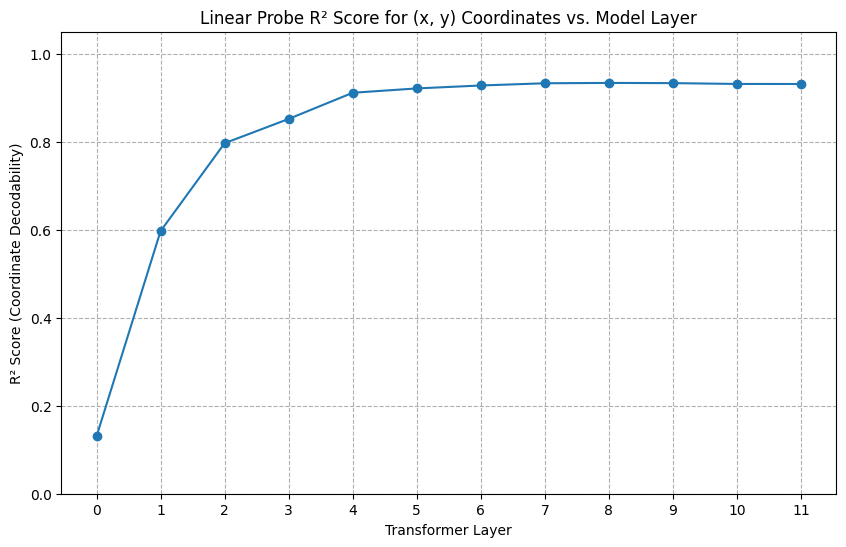

Best coordinate representation: Layer 8 (R² = 0.9336)


In [ ]:
# Probe Training and Analysis

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

activation_data = torch.load(ACTIVATION_CACHE_PATH)
num_layers = model.config.n_layer

activations_by_layer = [[] for _ in range(num_layers)]
labels = []

for point in activation_data:
    for layer_idx in range(num_layers):
        activations_by_layer[layer_idx].append(point['activations'][layer_idx])
    labels.append([point['x'], point['y']])

for i in range(num_layers):
    activations_by_layer[i] = torch.stack(activations_by_layer[i]).numpy()
labels = np.array(labels)

probe_scores = []

for layer_idx in tqdm(range(num_layers), desc="Training probes"):
    X = activations_by_layer[layer_idx]
    y = labels
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    probe = LinearRegression()
    probe.fit(X_train, y_train)
    
    score = probe.score(X_test, y_test)
    probe_scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(range(num_layers), probe_scores, marker='o', linestyle='-')
plt.title('Linear Probe R² Score for (x, y) Coordinates vs. Model Layer')
plt.xlabel('Transformer Layer')
plt.ylabel('R² Score (Coordinate Decodability)')
plt.xticks(range(num_layers))
plt.ylim(0, 1.05)
plt.grid(True, which='both', linestyle='--')
plt.show()

best_layer = np.argmax(probe_scores)
best_score = probe_scores[best_layer]
print(f"Best coordinate representation: Layer {best_layer} (R² = {best_score:.4f})")